# Инфо по выделенным ресурсам

*Разбор данного раздела:* https://youtu.be/wsediS2w5vY?t=422

In [ ]:
# Connect Faster GPUs
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Nov 22 12:09:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 27.4 gigabytes of available RAM



# Генетические алгоритмы для обучения нейронных сетей

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

In [ ]:
#Загружаем библиотеки

import pandas as pd # Пандас
import matplotlib.pyplot as plt # Отрисовка графиков
from tensorflow.keras import utils # Для to_categorical
import numpy as np # Numpy
from keras.optimizers import Adam # Оптимизатор
from keras.models import Sequential, Model # Два варианты моделей
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D#Стандартные слои
from keras.losses import MAE
from google.colab import files # Загрузка файлов
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Нормировщики
from keras.preprocessing.sequence import TimeseriesGenerator # Для генерации выборки временных рядов
import keras.backend as K
import random as random # Импортируем модель randim
import numpy as np # Импортируем библиотеку numpy
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from PIL import Image # Импортируем одель Image для обработки изображений
import time
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Подбор архитектуры свёрточной сети

#Прогнозирование трафика

*Разбор данного раздела:* https://youtu.be/wsediS2w5vY?t=1094


In [ ]:
# Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/MyDrive/traff.csv',header=None)

In [ ]:
# Выводим пять первых строк
base_data.head(20)

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"
5,1/6/2017,"29,354.00"
6,1/7/2017,"29,139.00"
7,1/8/2017,"31,244.00"
8,1/9/2017,"32,690.00"
9,1/10/2017,"31,299.00"


In [ ]:
base_data.shape

(1095, 2)

In [ ]:
data = base_data.iloc[:,1]

In [ ]:
# Выводим параметры одного фала
d = data
print(len(d))         # Сколько есть записей
print(len(d.iloc[0])) # Длинна одной строки данных
print(d.iloc[0])      # Пример первой строки данных

1095
9
22,226.00


In [ ]:
data = np.array(data) #Превращаем в numpy массив
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

**Функция загрузки данных**

In [ ]:
#Формируем параметры загрузки данных
xLen = 60     # Анализируем по 300 прошедшим точкам 
valLen = 300  # Используем 300 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

# Делим данные на тренировочную и тестовую выборки 
Train,Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)


# Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(Train, Train,             # в качестве параметров наши выборки
                               length=xLen, sampling_rate=1, # для каждой точки
                               batch_size=20)                # размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

**Функции для отображения результатов**

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(figsize=(18,10))
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
# showGraf - показываем график или нет
# returnData - возвращаем массивы автокорреляции или нет
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if showGraf: #Если нужно показать график
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData: #Если нужно вернуть массивы автокорреляции
    return corr, own_corr

**Генерируем проверочную выборку**

In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=len(Test)) # Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

# Подбор линейной архитектуры

*Разбор данного раздела:* https://youtu.be/wsediS2w5vY?t=1482


**Входной слой**

*   0 - делаем ли нормализацию
*   1 - размер первого свёрточного слоя
*   2 - ядро первого свёрточного слоя 
*   3 - функция активации первого слоя
*   4 - делаем ли MaxPooling0
*   5 - размер MaxPooling0

**Первый скрытый слой**

*   6 - Делаем ли второй сверточный слой
*   7 - размер второго сверточного слоя
*   8 - ядро второго сверточного слоя
*   9 - делаем ли MaxPooling1
*   10 - размер MaxPooling1
*   11 - функция активации

**Второй скрытый слой**

*   12 - Делаем ли третий сверточный слой
*   13 - размер третьего сверточного слоя
*   14 - ядро третьего сверточного слоя
*   15 - делаем ли MaxPooling2
*   16 - размер MaxPooling2
*   17 - функция активации 
----
*   18 - функция активации предпоследнего слоя
*   19 - функция активации выходного слоя
----
**Третий(предпоследний) скрытый слой**

*   20 - делаем ли нормализацию 
*   21 - размер полносвязного слоя

In [ ]:
#Создаём сеть (net - список параметров)
def createConvNet(net):

  model = Sequential()             # Создаем моель Sequential
  
  makeFirstNormalization = net[0]  # Делаем ли нормализацию в начале
  firstConvSize = 2 ** net[1]      # Размер первого вёрточного слоя
  firstConvKernel = net[2]         # Ядро первого свёрточного слоя
  activation0 = net[3]             # Функция активации входного слоя
  makeMaxPooling0 = net[4]         # Делаем ли maxpooling для нулевого слоя
  maxPoolingSize0 = net[5]         # Размер MaxPooling

  makeSecondConv = net[6]          # Делаем ли второй свёрточный слой
  secondConvSize = 2 ** net[7]     # Размер второго свёрточного слоя
  secondConvKernel = net[8]        # Ядро второго свёрточного слоя
  makeMaxPooling1 = net[9]         # Делаем ли MaxPooling
  maxPoolingSize1 = net[10]        # Размер MaxPooling
  activation1 = net[11]            # Функция активации

  makeThirdConv = net[12]          # Делаем ли второй свёрточный слой
  thirdConvSize = 2 ** net[13]     # Размер второго свёрточного слоя
  thirdConvKernel = net[14]        # Ядро второго свёрточного слоя
  makeMaxPooling2 = net[15]        # Делаем ли MaxPooling
  maxPoolingSize2 = net[16]        # Размер MaxPooling
  activation2 = net[17]            # Функция активации

  activation3 = net[18]            # Функция активации для 
  activation4 = net[19]            # Функция активации для последнего слоя

  makeSecondNormalization = net[20] # Делаем ли финальную нормализацию
  denseSize = 2 ** net[21]          # Размер полносвязного слоя

  activation_list = ['linear','relu','tanh','softmax','sigmoid'] 

  if (makeFirstNormalization):      # Если делаем нормализацию в начале

    # Добавляем слой BatchNormalization
    model.add(BatchNormalization(input_shape=(xLen, 1))) 

    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same')) 
  else:

    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, 1), activation=activation_list[activation0], padding='same')) 

  if makeMaxPooling0:               # Если делаем maxpooling
    model.add(MaxPooling1D(maxPoolingSize0))


  if (makeSecondConv):              # Если делаем второй свёрточный слой
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding='same')) 
    
    if (makeMaxPooling1):           # Если делаем MaxPooling
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize1)) 


  if (makeThirdConv):               # Если делаем второй свёрточный слой
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding='same')) 

    if (makeMaxPooling2):           # Если делаем MaxPooling
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize, maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize2)) 
          
  if (makeSecondNormalization):     # Если делаем финальную нормализацию
    model.add(BatchNormalization()) # Добавляем слой BatchNormalization
  
  model.add(Flatten())              # Добавляем слой Flatten

  model.add(Dense(denseSize, activation=activation_list[activation3])) # Добавляем слой Dense с denseSize нейронами
  model.add(Dense(1, activation=activation_list[activation4]))         # Добавляем Dense-слой с softmax-активацией и 10 нейронами
  
  return model                      # Возвращаем модель

'''
  Функция вычисления результата работы сети
'''

def evaluateNet(net, ep, verb):
  val = 0
  time.time()
  model = createConvNet(net) # Создаем модель createConvNet

  # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-4),
                  loss='mse')

  history = model.fit(trainDataGen,
                    epochs=ep, 
                    verbose=verb,
                    validation_data=testDataGen)
    
  val = history.history["val_loss"][-1] # Возвращаем точность на проверочной выборке с последней эпохи
  
  return val, model                      # Возвращаем точность

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) #Делаем или нет нормализацию
  net.append(random.randint(3,6)) #Первый свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) #Ядро первого свёрточного слоя от 3 до 7
  net.append(random.randint(0,4)) # Функция активации первого слоя
  net.append(random.randint(0,1)) #Делаем ли MaxPooling
  net.append(random.randint(2,5)) #Размер MaxPooling

  net.append(random.randint(0,1)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,6)) # Второй свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,5)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,1)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,6)) # Второй свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,5)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,4)) # Функция активации предпоследнего dense слоя
  net.append(random.randint(0,2)) # Функция активации последнего слоя

  net.append(random.randint(0,1)) # Делаем ли финальную нормализацию слой
  net.append(random.randint(3,6)) # Размер полносвязного слоя от 8 до 64
  
  return net

In [ ]:
n = 20              # Общее число ботов
nsurv = 10          # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 22              # Размер бота
epohs = 10          # количество эпох

mut = 0.09          # коэфициент мутаций

popul = []          # Массив популяции
val = []            # Одномерный массив значений этих ботов

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):                 # Пробегаем по всем эпохам
  val = []                              # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):                    # Пробегаем в цикле по всем ботам 
    bot = popul[i]                      # Берем очередного бота
    f, model_sum = evaluateNet(bot, 3, 0) # Вычисляем точность текущего бота
    val.append(f)                       # Добавляем полученное значение в список val
  
  sval = sorted(val, reverse=0)         # Сортируем val
  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине размерности (784)      
      x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

0 30.71854567527771   [0.06547316908836365, 0.07171739637851715, 0.0749555230140686, 0.10859611630439758, 0.16712336242198944] [[0, 3, 4, 2, 1, 2, 1, 4, 6, 1, 5, 4, 0, 4, 4, 0, 2, 3, 3, 0, 1, 3], [0, 5, 7, 2, 0, 2, 1, 6, 6, 1, 5, 0, 0, 4, 4, 0, 3, 4, 1, 1, 1, 5], [1, 4, 4, 4, 1, 3, 0, 6, 3, 0, 4, 3, 1, 4, 5, 0, 2, 4, 0, 1, 0, 4], [1, 5, 6, 3, 1, 2, 1, 4, 7, 1, 2, 4, 0, 3, 7, 0, 4, 1, 4, 2, 1, 6], [1, 5, 5, 0, 1, 2, 1, 5, 6, 0, 5, 4, 1, 3, 7, 0, 2, 4, 2, 2, 0, 3]]
1 28.566004037857056   [0.07765483111143112, 0.08553218841552734, 0.08727899193763733, 0.09534972906112671, 0.10161911696195602] [[0, 6, 7, 0, 0, 5, 1, 4, 7, 1, 4, 0, 0, 6, 4, 0, 5, 0, 4, 0, 1, 4], [1, 6, 6, 4, 1, 3, 0, 6, 7, 0, 3, 2, 0, 5, 4, 0, 5, 4, 1, 1, 0, 3], [1, 5, 5, 0, 1, 2, 1, 5, 6, 0, 5, 4, 1, 3, 7, 0, 2, 4, 2, 2, 0, 3], [1, 4, 5, 3, 1, 5, 0, 3, 3, 0, 3, 3, 0, 6, 5, 1, 3, 4, 2, 1, 0, 6], [0, 6, 7, 3, 1, 3, 1, 6, 3, 1, 3, 1, 1, 6, 7, 0, 3, 4, 3, 2, 0, 6]]
2 28.162293434143066   [0.07177077978849411, 0.071930065751075

In [ ]:
print(popul) #Геномы лучших ботов по эпохам

[[0, 6, 6, 0, 1, 2, 0, 5, 6, 1, 5, 4, 0, 6, 5, 0, 2, 1, 2, 2, 0, 6], [0, 5, 3, 0, 1, 2, 0, 6, 3, 1, 5, 3, 0, 3, 5, 0, 2, 0, 2, 2, 0, 6], [0, 5, 3, 0, 1, 2, 0, 5, 6, 1, 5, 4, 0, 4, 5, 0, 2, 1, 2, 2, 0, 6], [0, 6, 6, 0, 1, 2, 0, 5, 7, 1, 5, 4, 0, 6, 4, 0, 2, 1, 2, 2, 0, 5], [0, 4, 3, 0, 1, 2, 0, 5, 3, 1, 5, 4, 0, 4, 7, 1, 3, 1, 2, 2, 0, 6], [0, 5, 3, 0, 1, 2, 0, 5, 3, 1, 5, 3, 0, 3, 5, 0, 2, 1, 2, 2, 0, 6], [0, 5, 6, 0, 1, 2, 0, 5, 6, 0, 4, 4, 1, 4, 5, 1, 2, 0, 2, 2, 0, 6], [0, 4, 3, 4, 1, 2, 0, 5, 5, 1, 5, 0, 0, 3, 4, 0, 2, 4, 2, 2, 0, 6], [0, 4, 3, 4, 1, 2, 0, 3, 5, 1, 5, 3, 0, 3, 4, 0, 2, 0, 2, 2, 0, 6], [0, 4, 6, 3, 0, 2, 0, 4, 7, 0, 5, 3, 1, 4, 7, 1, 4, 1, 2, 2, 0, 6], [0, 6, 3, 0, 1, 2, 0, 5, 6, 1, 5, 3, 0, 6, 5, 0, 2, 1, 2, 2, 0, 6], [0, 6, 3, 0, 1, 2, 0, 4, 7, 1, 5, 4, 0, 4, 4, 0, 2, 0, 2, 2, 0, 5], [0, 5, 3, 0, 1, 2, 0, 5, 3, 1, 5, 3, 0, 3, 5, 0, 2, 0, 2, 2, 0, 6], [0, 4, 3, 4, 0, 2, 0, 3, 6, 1, 5, 3, 0, 5, 5, 0, 2, 0, 2, 2, 0, 6], [0, 4, 3, 0, 1, 2, 0, 6, 3, 1, 5, 3, 0, 3, 5, 0

In [ ]:
model = createConvNet(popul[0])
model.summary()


Model: "sequential_401"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_687 (Conv1D)          (None, 60, 64)            448       
_________________________________________________________________
max_pooling1d_340 (MaxPoolin (None, 30, 64)            0         
_________________________________________________________________
flatten_401 (Flatten)        (None, 1920)              0         
_________________________________________________________________
dense_802 (Dense)            (None, 64)                122944    
_________________________________________________________________
dense_803 (Dense)            (None, 1)                 65        
Total params: 123,457
Trainable params: 123,457
Non-trainable params: 0
_________________________________________________________________


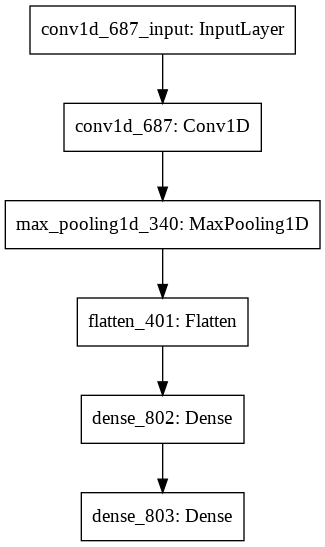

In [ ]:
plot_model(model)

In [ ]:
#Комипилируем и обучаем
model.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

history = model.fit_generator(trainDataGen,
                    epochs=50, 
                    validation_data=testDataGen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0195 - val_loss: 0.0372
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0305
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0188
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0142
Epoch 5/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0175
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0102
Epoch 7/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 8/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0101
Epoch 9/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0110
Epoch 10/50
37/37 [=======================

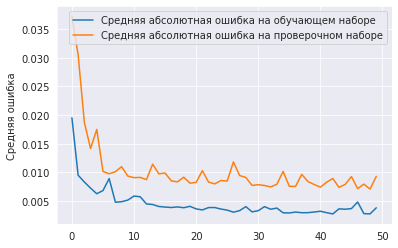

In [ ]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

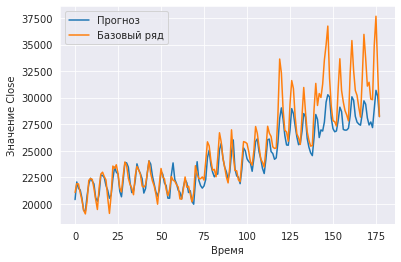

In [ ]:
# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

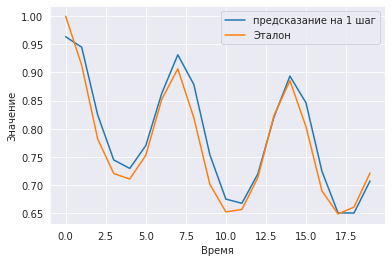

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 20, predVal, yValUnscaled)

# Пример "человеческой сборки" нелинейной

*Разбор данного раздела:* https://youtu.be/wsediS2w5vY?t=3594



Epoch 1/50
37/37 [==============================] - 0s 8ms/step - loss: 0.3078 - val_loss: 0.0753
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0309 - val_loss: 0.0153
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0223
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0181
Epoch 5/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0298 - val_loss: 0.0130
Epoch 6/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0574 - val_loss: 0.0155
Epoch 7/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0215
Epoch 8/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0156 - val_loss: 0.0240
Epoch 9/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0060
Epoch 10/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 0.0411
Epoch 11/50
37/37 [

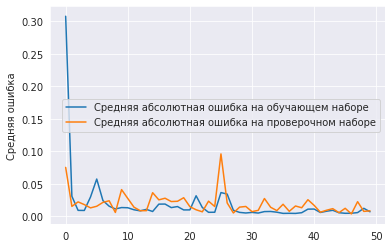

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину shape = (xLen, 1)
shape = (xLen, 1)

inputs = Input(shape)
list_to_concat = [inputs]

x = BatchNormalization()(inputs)
maxPoolingSize = 3

x = Conv1D(2**6,3,padding='same')(x)
x = Activation('linear')(x)
list_to_concat.append(x)

x = Conv1D(2**6,5,padding='same')(x)
x = Activation('tanh')(x)
list_to_concat.append(x)

x = Conv1D(2**8,5,padding='same')(x)
x = Activation('linear')(x)
list_to_concat.append(x)

for i in range(len(list_to_concat)):
  list_to_concat[i]=Flatten()(list_to_concat[i])

fin = concatenate(list_to_concat)
fin = Dense(2**6)(fin)
fin = Activation('linear')(fin)

fin = Dense(1)(fin)

modelC = Model(inputs, fin)

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

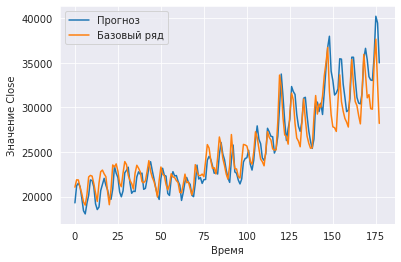

In [ ]:
# Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

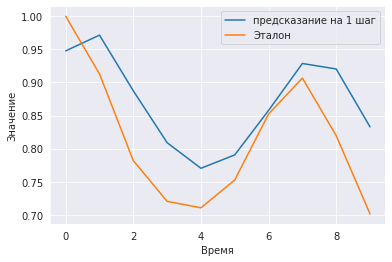

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 10, predVal, yValUnscaled)

# Подбор нелинейной архитектуры



**БЛОК 1**
*   0 - делаем ли нормализацию
*   1 - размер MaxPooling для всех слоев

*   2 - размер первого свёрточного слоя
*   3 - ядро первого свёрточного слоя
*   4 - функция активации первого слоя

**БЛОК 2**
*   5 - делаем ли второй свёрточный слой
*   6 - размер второго свёрточного слоя
*   7 - ядро второго свёрточного слоя
*   8 - делаем ли MaxPooling
*   9 - функция активации второго слоя 

**БЛОК 3**
*   10 - делаем ли второй свёрточный слой
*   11 - размер второго свёрточного слоя
*   12 - ядро второго свёрточного слоя
*   13 - делаем ли MaxPooling
*   14 - функция активации второго слоя 

**БЛОК 4**
*   15 - делаем ли второй свёрточный слой
*   16 - размер второго свёрточного слоя
*   17 - ядро второго свёрточного слоя
*   18 - делаем ли MaxPooling
*   19 - функция активации второго слоя 

**БЛОК 5**
*   20 - делаем ли второй свёрточный слой
*   21 - размер второго свёрточного слоя
*   22 - ядро второго свёрточного слоя
*   23 - делаем ли MaxPooling
*   24 - функция активации второго слоя 

**БЛОК 6**
*   25 - делаем ли нормализацию перед полносвязным слоем
*   26 - делаем ли полносвязный слой
*   27 - размер полносвязного слоя

In [ ]:
#Создаём сеть (net - список параметров)
def createConvNet(net):
  
  makeFirstNormalization = net[0] # Делаем ли нормализацию в начале
  maxPoolKernel = net[1]          # Ядро пуллинга

  firstConvSize = 2 ** net[2]     # Размер первого cвёрточного слоя
  firstConvKernel = net[3]        # Ядро первого свёрточного слоя
  activation1 = net[4]            # Функция активации первого слоя

  makeConv2 = net[5]              # Делаем ли второй сверточный слой
  secondConvSize = 2 ** net[6]    # Ядро второго свёрточного слоя
  secondConvKernel = net[7]       # Размер второго свёрточного слоя
  makePool2 = net[8]              # Делаем ли пуллинг?
  activation2 = net[9]            # Функция активации второго слоя

  makeConv3 = net[10]             # Делаем ли  сверточный слой
  thirdConvSize = 2 ** net[11]    # Ядро третьего свёрточного слоя
  thirdConvKernel = net[12]       # Размер третьего свёрточного слоя
  makePool3 = net[13]             # Делаем ли пуллинг?
  activation3 = net[14]           # Функция активации третьего слоя

  makeConv4 = net[15]             # Делаем ли  сверточный слой
  fourthConvSize = 2 ** net[16]   # Ядро четвертого свёрточного слоя
  fourthConvKernel = net[17]      # Размер четвертого свёрточного слоя
  makePool4 = net[18]             # Делаем ли пуллинг?
  activation4 = net[19]           # Функция активации четвертого слоя

  makeConv5 = net[20]             # Делаем ли  сверточный слой
  fifthConvSize = 2 ** net[21]    #  Ядро пятого свёрточного слоя
  fifthConvKernel = net[22]       # Размер пятого свёрточного слоя
  makePool5 = net[23]             # Делаем ли пуллинг?
  activation5 = net[24]           # Функция активации пятого слоя
  

  makeDense = net[25]             # Делаем ли полносвязный
  denseSize = 2 ** net[26]        # Размер полносвязного слоя
  activation6 = net[27]           # Фукнция активации пятго слоя

  shape = (xLen, 1)               # Размер входных данных
  inputs = Input(shape)           # Входной слой

  # Список активационных функций
  activation_list = ['linear','relu','tanh','softmax','sigmoid']

  if (makeFirstNormalization):    # Если делаем нормализацию в начале
    x = BatchNormalization()(inputs)
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(x)
    x1 = Activation(activation_list[activation1])(x)

  else:                           # Если не делаем нормализацию в начале
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(inputs)
    x = Activation(activation_list[activation1])(x)

  list_to_concat = [inputs]       # Этот список будем потом склеивать

  for i in range(4):              # Проходимся по каждому блоку
    if net[5+5*i]!=0:             # Добавление блока
      x = Conv1D(net[6+5*i],net[7+5*i], padding ='same')(x)
      x = Activation(activation_list[net[5*i+4]])(x)
    #   x = Reshape((-1,1))(x)

      if net[8+5*i]!=0:           # Добавление пулинга
        x = MaxPooling1D(maxPoolKernel)(x)
        list_to_concat.append(x)  # Добавляем в список
      #  print(x)
      else:
        list_to_concat.append(x)  # Иначе сразу добавляем в список
 
    #   list_to_concat.append(x)    # Добавляем в список

  # Проходим по всем значениям списка list_to_concat и делаем flatten
  for i in range(len(list_to_concat)):    
    if list_to_concat[i].shape != (None,0,1):
      list_to_concat[i] = Flatten()(list_to_concat[i]) 
    else:
      break

  # Соединяем значения списка в единое целое
  if len(list_to_concat) != 1:
     fin = concatenate(list_to_concat)
  
  # Иначе просто делаем flatten
  else:
    fin = x
    fin = Flatten()(fin)

  # Добавление полносвязного слоя
  if makeDense!=0:
    fin = Dense(denseSize)(fin)
    fin = Activation(activation_list[activation6])(fin)

  fin = Dense(1)(fin)

  model = Model(inputs, fin)  # Создаем моель Sequential
  return model                # Возвращаем моель

'''
  Функция вычисления резульата работы сети
'''
def evaluateNet(net, ep, verb):
  val = 0
  model = createConvNet(net)  # Создаем модель createConvNet
  # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-4),
                  loss='mse')

  history = model.fit_generator(trainDataGen,
                    epochs=5, 
                    verbose=verb,
                    validation_data=testDataGen)
  # Прогнозируем данные текущей сетью
  (predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0], Scaler) #Прогнозируем данные
  
  # Возвращаем автокорреляцию 
  corr, own_corr = autoCorr([0], 5, predVal, yValUnscaled, showGraf = False, returnData = True)
  val = MAE(corr, own_corr).numpy() * history.history["val_loss"][-1] #Считаем MAE и прибавляем ошибку

  return val, model # Возвращаем точность

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) # Делаем или нет нормализацию
  net.append(random.randint(2,3)) # Ядро maxPooling

  net.append(random.randint(3,10)) # Первый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро первого свёрточного слоя от 3 до 7
  net.append(random.randint(0,4))  # Функция активации
  

  net.append(random.randint(0,1))  # Делаем ли второй сверточный
  net.append(random.randint(3,10)) # Второй свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли третий сверточный
  net.append(random.randint(3,10)) # Третий свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро третьего свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли четвертый сверточный
  net.append(random.randint(3,10)) # Четвертый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро четвертого свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли пятый сверточный
  net.append(random.randint(3,10)) # Пятый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро пятого свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли полносвязный слой
  net.append(random.randint(3,10)) # Размер полносвязного слоя от 8 до 1024
  net.append(random.randint(0,4))  # Функция активации
  return net

In [ ]:
n = 20                    # Общее число ботов
nsurv = 7                 # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv          # Количество новых (столько новых ботов создается)
l = 28                    # Размер бота
epohs = 9                 # количество эпох
mut = 0.4                 # коэфициент мутаций

popul = []                # Массив популяции
val = []                  # Одномерный массив значений этих ботов

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):   # Пробегаем по всем эпохам
  val = []                # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):      # Пробегаем в цикле по всем ботам 
    bot = popul[i]        # Берем очередного бота

    # Вычисляем точность текущего бота
    f,model_sum = evaluateNet(bot, 3, 0) 
    val.append(f)         # Добавляем полученное значение в список val

  # Сортируем val
  sval = sorted(val, reverse=0) 

  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time,  " ", sval[0:5],popul[:5]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине размерности (784)      
      x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

0 35.15745210647583   [0.0007584818881862131, 0.0007999599565860355, 0.0012282595920450287, 0.001696022161381173, 0.0017031220711275184] [[1, 2, 10, 6, 4, 1, 5, 5, 1, 0, 1, 9, 4, 1, 4, 1, 10, 3, 1, 1, 1, 8, 3, 1, 0, 1, 7, 3], [1, 2, 3, 6, 1, 1, 7, 6, 0, 2, 0, 7, 7, 1, 3, 0, 3, 3, 1, 0, 0, 5, 6, 0, 2, 1, 9, 0], [1, 2, 4, 4, 2, 1, 6, 6, 0, 4, 1, 4, 5, 0, 3, 1, 10, 3, 1, 4, 0, 4, 4, 0, 4, 1, 4, 0], [1, 2, 8, 3, 2, 1, 3, 5, 1, 4, 1, 4, 4, 0, 2, 1, 4, 6, 0, 3, 1, 8, 7, 1, 3, 0, 6, 3], [0, 2, 9, 6, 1, 1, 6, 3, 0, 2, 1, 7, 4, 1, 2, 1, 7, 3, 0, 3, 1, 3, 4, 0, 2, 0, 4, 1]]
1 32.35274863243103   [0.00042330381086285585, 0.0008384126424229873, 0.0008912072051052594, 0.0009120395464314709, 0.0011165827547028734] [[1, 2, 3, 6, 1, 1, 7, 6, 0, 2, 0, 7, 7, 1, 3, 0, 3, 3, 1, 0, 0, 5, 6, 0, 2, 1, 9, 0], [0, 3, 10, 5, 2, 1, 8, 4, 0, 2, 0, 10, 4, 1, 0, 1, 9, 3, 0, 3, 1, 8, 4, 0, 2, 1, 5, 1], [1, 2, 4, 4, 2, 1, 6, 6, 0, 4, 1, 4, 5, 0, 3, 1, 10, 3, 1, 4, 0, 4, 4, 0, 4, 1, 4, 0], [0, 2, 5, 4, 4, 0, 3, 5, 1, 

## Проверка результатов

*Разбор данного раздела:* https://youtu.be/wsediS2w5vY?t=4382


In [ ]:
print(popul) #Геномы лучших ботов по эпохам

[[0, 3, 7, 5, 2, 0, 8, 5, 0, 1, 0, 7, 7, 1, 3, 0, 9, 4, 0, 1, 0, 9, 5, 0, 1, 1, 10, 1], [0, 3, 4, 6, 2, 0, 4, 3, 1, 1, 0, 7, 6, 1, 0, 0, 3, 4, 0, 2, 0, 3, 7, 0, 1, 1, 10, 1], [0, 2, 8, 5, 1, 1, 9, 3, 0, 0, 1, 3, 4, 1, 2, 0, 5, 3, 0, 1, 1, 6, 6, 0, 1, 1, 10, 2], [0, 2, 8, 4, 1, 1, 6, 4, 1, 1, 1, 7, 7, 0, 2, 1, 8, 3, 0, 0, 1, 9, 5, 1, 1, 1, 9, 2], [0, 2, 4, 5, 0, 0, 3, 3, 1, 2, 1, 7, 4, 1, 0, 0, 9, 4, 0, 2, 0, 3, 7, 1, 2, 1, 10, 1], [0, 2, 4, 4, 0, 1, 4, 4, 1, 2, 1, 9, 4, 0, 2, 0, 5, 4, 1, 1, 0, 8, 5, 0, 3, 1, 8, 2], [0, 2, 4, 3, 0, 1, 4, 4, 0, 2, 1, 7, 4, 1, 0, 1, 8, 7, 0, 1, 1, 10, 7, 0, 0, 1, 9, 0], [0, 2, 4, 7, 3, 0, 9, 3, 1, 2, 0, 3, 6, 1, 4, 0, 3, 3, 0, 2, 0, 3, 7, 1, 1, 1, 10, 3], [0, 2, 3, 4, 0, 1, 4, 4, 1, 2, 0, 9, 4, 0, 2, 1, 5, 4, 1, 1, 0, 10, 5, 1, 2, 1, 10, 2], [0, 3, 4, 5, 1, 1, 8, 4, 1, 1, 0, 9, 6, 1, 0, 0, 5, 4, 1, 1, 1, 9, 4, 0, 3, 1, 10, 1], [0, 2, 6, 4, 0, 1, 6, 7, 1, 2, 1, 9, 4, 1, 4, 0, 9, 4, 0, 1, 0, 6, 7, 0, 2, 1, 10, 3], [1, 3, 4, 6, 1, 1, 6, 4, 1, 2, 1, 4, 3, 0, 

In [ ]:
model = createConvNet(popul[0])
model.summary()

Model: "functional_371"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_186 (InputLayer)       [(None, 60, 1)]           0         
_________________________________________________________________
conv1d_1288 (Conv1D)         (None, 60, 128)           768       
_________________________________________________________________
activation_754 (Activation)  (None, 60, 128)           0         
_________________________________________________________________
flatten_1015 (Flatten)       (None, 7680)              0         
_________________________________________________________________
dense_1143 (Dense)           (None, 1024)              7865344   
_________________________________________________________________
activation_755 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_1144 (Dense)           (None, 1)              

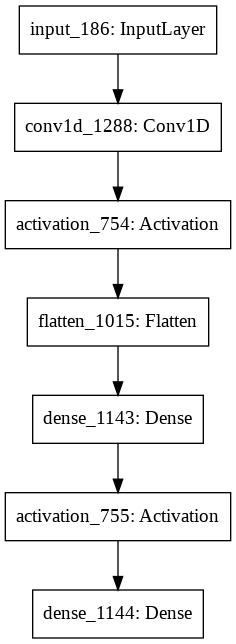

In [ ]:
plot_model(model)

In [ ]:
#Комипилируем и обучаем
model.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

history = model.fit_generator(trainDataGen,
                    epochs=50, 
                    validation_data=testDataGen)

Epoch 1/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0629 - val_loss: 0.0592
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0153 - val_loss: 0.0139
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0142 - val_loss: 0.0144
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 5/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 7/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 0.0167
Epoch 8/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0146
Epoch 9/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0106
Epoch 10/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 11/50
37/37 [

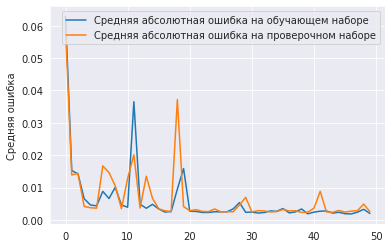

In [ ]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

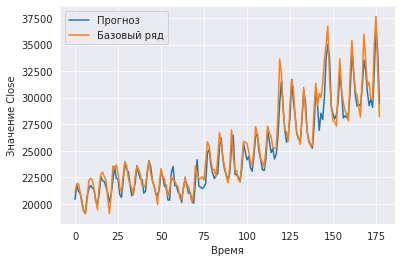

In [ ]:
# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

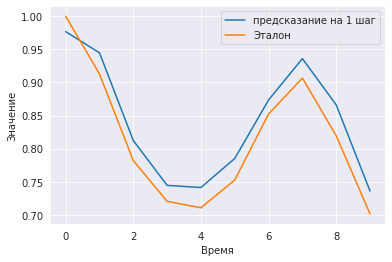

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 10, predVal, yValUnscaled)

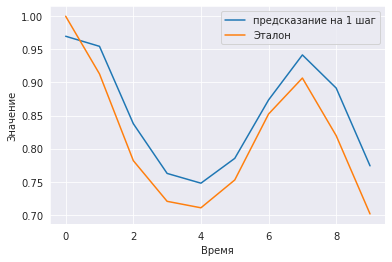

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 10, predVal, yValUnscaled)